In [191]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
import numpy as np
import pandas as pd
import preprocess
import spacy
from collections import Counter
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import preprocess
from nltk.tokenize import sent_tokenize
from gensim.models import word2vec
from gensim.models import Doc2Vec
import logging
from featurize import Corpus_Features
import re
import chardet
import ftfy
from gensim.models import Word2Vec
from sklearn.cross_validation import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

from gensim_modeling import cleanText
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Goal: Produce the best model for classifying Stack Exchange questions 

# First order of business: Preprocessing

In [18]:
"""Load in data with the most stringent preprocessing"""
balanced_classes_file = open("pickle_jar/dataframes/classify_Stopwords_3xTitle_ner_stripPunct_lemmatize_dataframe.p", 'rb')
balanced_classes_data = pickle.load(balanced_classes_file)

balanced_classes_tag_counter_file = open('pickle_jar/tag_counters/classify_Stopwords_3xTitle_ner_stripPunct_lemmatize_tag_counts.p', 'rb')
balanced_classes_tag_counter = pickle.load(balanced_classes_tag_counter_file)

balanced_classes_bow_counter_file = open('pickle_jar/post_counters/classify_Stopwords_3xTitle_ner_stripPunct_lemmatize_token_counts.p', 'rb')
balanced_classes_bow_counter = pickle.load(balanced_classes_bow_counter_file)


thread_dict = {'biology':0,'cooking':1,'crypto':2,'diy':3,'robotics':4,'travel':5}
balanced_classes_data['thread_ids'] = balanced_classes_data.thread.apply(lambda x: thread_dict[x]).values

In [11]:
def view_example_post(index):
    print("QUESTION:\n{}\n".format(balanced_classes_data['title'].iloc[index]))

    print("ELABORATION:\n{}\n".format(balanced_classes_data['content'].iloc[index]))

    print("TAGS:\n{}\n".format(balanced_classes_data['tags'].iloc[index]))

    print("CLASS: ***{}***".format(balanced_classes_data['thread'].iloc[index]))

view_example_post(np.random.randint(0,len(balanced_classes_data)))

QUESTION:
How do you decide what temperature to bake at?

ELABORATION:
<p>What is the logic behind the choice of temperature for baking?</p>

<p>Obviously if you're following a recipe it will say what temperature to use, but I'd like to understand the reasoning behind it.</p>

<p>Is it a matter of density (thicker foods need to be cooked lower to reach the inside without burning the outside), or are there other factors in play?</p>


TAGS:
['b', 'baking', 'oven', 'temperature']

CLASS: ***cooking***


## Words in the title of a question are really valuable for predicting topics...
**I duplicated each title 3X (triple_title) and inserted tiple_title at the beginning of of context (ttl_ctxt).**

```python
def triple_title(self):
    self.data['triple_title'] = (' '+self.data['title']) *3
    
def concat_features(self, features):m
    baseline = self.data[features[0]]
    concatenated = baseline.str.cat(''+self.data[features[1]])
    self.data['ttl_ctxt'] = concatenated
```


# Preprocessing Steps/Options

** 0. Unicode sandwhich**
```python
def clean_text(x):
    '''INPUT: string;
       OUTPUT: list of tokens.'''

    #Fix encoding in case there is a problem
    x = ftfy.fix_encoding(x)
    #Unicode Sandwhich...
    x = x.encode('UTF-8') #encode as UTF-8
    input_code = chardet.detect(bytes(x))['encoding'] #Auto-detect encoding
    u_string = x.decode(input_code) #Decode
    re.sub(r'\w{4}', u'xxxx', u_string, flags=re.UNICODE) #Handle funny unicode artifacts
    x = u_string.encode('UTF-8') #Encode back to UTF-8
    x = str(x) #Convert to string
    
    x = re.sub(r'[\[\]\"\'\,]',' ', x) #Remove backslashes
    x = re.sub(r'[^\w\s]',' ',x) #Insert space after end of each sentence
    x = x.split() #split string to list
    return x
```

**1. Strip html tags using BeautifulSoup.**
```python
soup = BeautifulSoup(x, 'html.parser')
clean_text = soup.text
```

**2. Convert named entities to ALLCAPS using spacy.**
```python
def capitalize_named_entities(text):
    nlp = spacy.en.English()
    spacy_text = nlp(text)
    output = []
    for t in spacy_text:
        if t.ent_type_ not in ['', 'DATE']:
            output.append(t.text.upper())
        else:
            output.append(t.text.lower())
    return ' '.join(output)
```

**3. Remove stopwords.**
```python
def remove_stopwords(text):
        tokens = text.split()
        output = []
        for t in tokens:
            if t not in stopwords.words():
                output.append(t)
        return ' '.join(output)
```

**4. Lemmatize.**
```python
def lemmatize_text(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    output = []
    for t in tokens:
        lemmanade =  wordnet_lemmatizer.lemmatize(t)
        lemmanade = wordnet_lemmatizer.lemmatize(lemmanade, pos='v')
        output.append(lemmanade)
    
    return ' '.join(output)
```

**5. Strip punctuation **
```python
def remove_punctuation(text):
    text_clean = re.sub(r'[^\w\s]',' ',text)
    return text_clean
```

# Features: 

### Bag of Words

In [81]:
def bag_of_words(post_strings):
    cv = CountVectorizer()
    bow  = cv.fit_transform(post_strings)
    return bow

In [82]:
post_lists = balanced_classes_data['ttl_ctxt'].apply(lambda x: cleanText(x))
post_strings = np.array([' '.join(pl) for pl in post_lists])
bow = bag_of_words(post_strings)

In [83]:
bow.shape

(6000, 33119)

### TFIDF

In [86]:
def TFIDF(post_strings):
    tfidf = TfidfVectorizer()
    tfidf_vec = tfidf.fit_transform(post_strings)
    return tfidf_vec

In [87]:
tfidf = TFIDF(post_strings)

In [41]:
tfidf.shape

(6000, 33119)

### Doc2Vec Embedding

In [43]:
from tsne_viz import *
from gensim_modeling import *

In [44]:
#Train model
d2v_balanced_classes_data = Doc2Vec(balanced_classes_data)

In [45]:
# store the model to mmap-able files
d2v_balanced_classes_data.save('doc2vec_models/balanced_classication.doc2vec')

In [47]:
tag_sentences = balanced_classes_data.tags.iloc[:].apply(lambda x: cleanText(' '.join(x)))
d2v_avg_embeddings = getAvgFeatureVecs(tag_sentences.values, d2v_balanced_classes_data, 300)

# Train and test and suite of models for BOW, TFIDF, and Doc2Vec
**Multinomial Naive Bayes, Random Forest, One vs Rest Logistic Regression, One vs Rest SVC, Gradient Boosted Trees**

- 5-fold cross-validation of each model: accuracy, f1, precision, and recall
- Confusion matrix generated by applying model to reserve set.

In [193]:
from model import *
from sklearn.model_selection import KFold
from pandas_ml import ConfusionMatrix

In [146]:
bow_platform = Classify_Thread(X=bow.toarray(),y=balanced_classes_data.thread_ids.values)

In [134]:
kf = KFold(5, shuffle=True)

## Gridsearched MNB

In [ ]:
# Gridsearched Multinomial Naive Bayes
mnb_bow = bow_platform.MNB_Gridsearch()

In [194]:
eval_dict = kfold_evaluation(bow_platform.x_test, bow_platform.y_test, model=mnb_bow, kf=kf)
pd.DataFrame.from_dict(eval_dict)

,accuracy,f1,precision,recall
train,0.988,0.988202,0.988276,0.988236
validate,0.988,0.987941,0.988007,0.988217


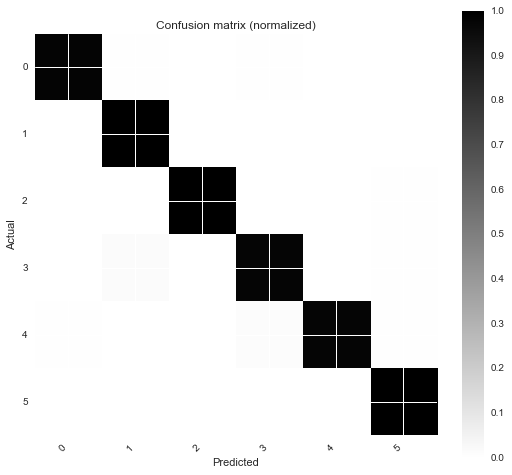

In [148]:
mnb_bow_pred = mnb_bow.predict(bow_platform.x_test)
ConfusionMatrix(bow_platform.y_test, mnb_bow_pred).plot(normalized=True)

### Random Forest

In [149]:
# Random Forest
rf_model = bow_platform.MNB_Gridsearch()
rf_eval_dict = kfold_evaluation(bow_platform.x_test, bow_platform.y_test, model=rf_model, kf=kf)
pd.DataFrame.from_dict(rf_eval_dict)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   59.8s finished


,accuracy,f1,precision,recall
train,0.999833,0.999848,0.999845,0.999853
validate,0.957333,0.957518,0.958190,0.957874


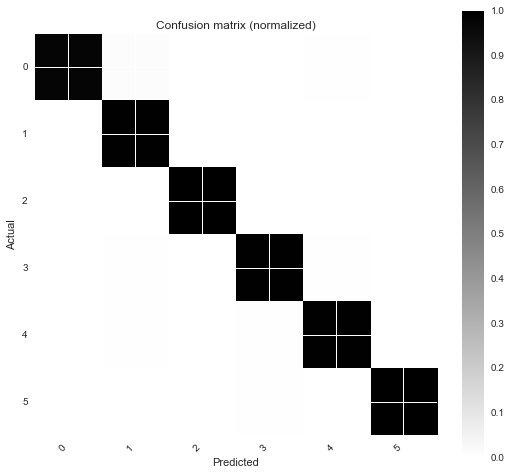

In [150]:
rf_bow_pred = rf_model.predict(bow_platform.x_test)
ConfusionMatrix(bow_platform.y_test, rf_bow_pred).plot(normalized=True)

### One vs Rest Logistic Regression

In [ ]:
lr_model = bow_platform.Logistic_Regression_OneVAll()

In [195]:
lr_eval_dict = kfold_evaluation(bow_platform.x_test, bow_platform.y_test, model=lr_model, kf=kf)
pd.DataFrame.from_dict(lr_eval_dict)

,accuracy,f1,precision,recall
train,0.967333,0.968050,0.968974,0.967562
validate,0.967333,0.968506,0.969949,0.967906


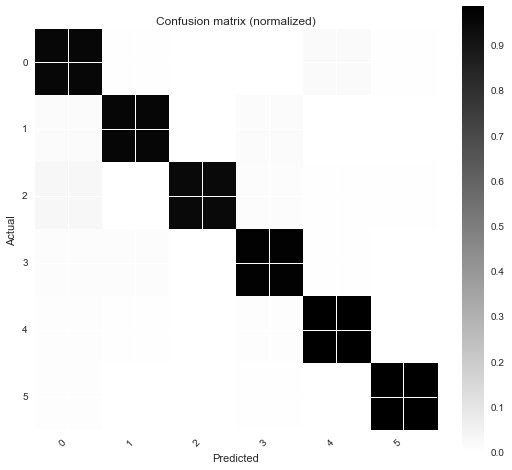

In [152]:
lr_bow_pred = lr_model.predict(bow_platform.x_test)
ConfusionMatrix(bow_platform.y_test, lr_bow_pred).plot(normalized=True)

### One vs Rest SVC

In [ ]:
svc_model = bow_platform.SVC_OneVAll()

In [196]:
svc_eval_dict = kfold_evaluation(bow_platform.x_test, bow_platform.y_test, model=svc_model, kf=kf)
pd.DataFrame.from_dict(svc_eval_dict)

,accuracy,f1,precision,recall
train,0.958,0.958835,0.960707,0.957918
validate,0.958,0.957169,0.959493,0.956758


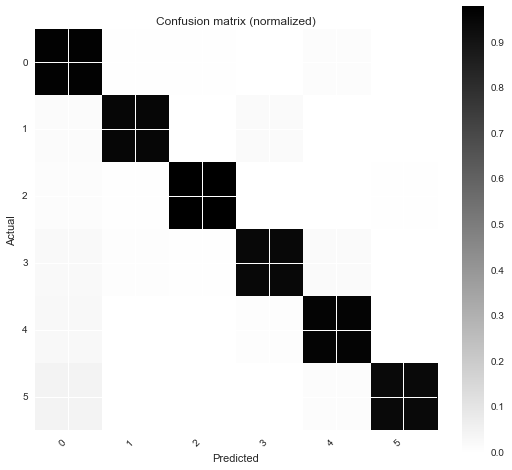

In [154]:
svc_bow_pred = svc_model.predict(bow_platform.x_test)
ConfusionMatrix(bow_platform.y_test, svc_bow_pred).plot(normalized=True)

### Gradient Boosted Trees


In [ ]:
gbt_model = bow_platform.Gradient_Boosted_Trees(n_rows=1000)

In [197]:
gbt_eval_dict = kfold_evaluation(bow_platform.x_test, bow_platform.y_test, model=gbt_model, kf=kf)
pd.DataFrame.from_dict(gbt_eval_dict)

,accuracy,f1,precision,recall
train,0.754667,0.777223,0.865288,0.753699
validate,0.754667,0.775708,0.865421,0.752765


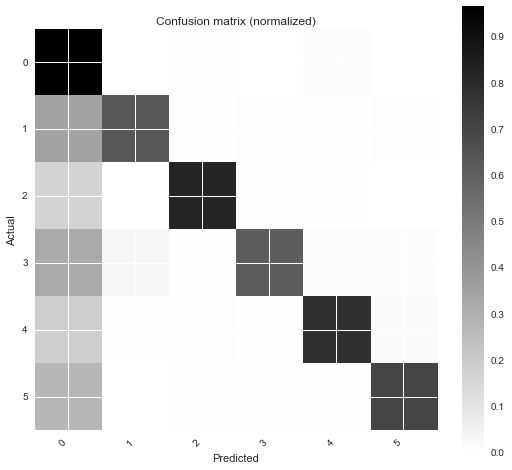

In [198]:
gbt_bow_pred = gbt_model.predict(bow_platform.x_test)
ConfusionMatrix(bow_platform.y_test, gbt_bow_pred).plot(normalized=True)

## TFIDF Modeling

In [161]:
tfidf_platform = Classify_Thread(X=tfidf.toarray(),y=balanced_classes_data.thread_ids.values)

### Gridsearched MNB

In [ ]:
# Gridsearched Multinomial Naive Bayes
mnb_tfidf = tfidf_platform.MNB_Gridsearch()

In [199]:
mbb_tfidf_eval_dict = kfold_evaluation(tfidf_platform.x_test, tfidf_platform.y_test, model=mnb_tfidf, kf=kf)
pd.DataFrame.from_dict(mbb_tfidf_eval_dict)

,accuracy,f1,precision,recall
train,0.99,0.990130,0.990019,0.990297
validate,0.99,0.989955,0.989984,0.990100


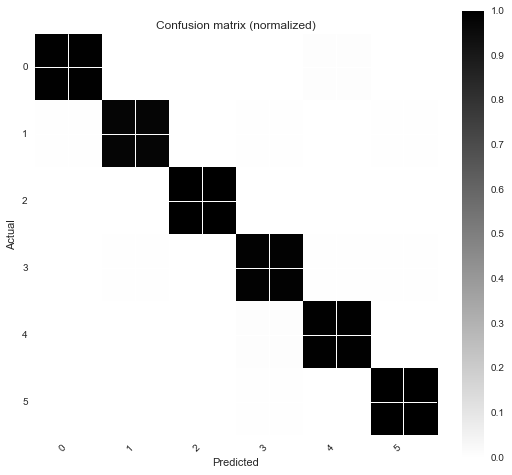

In [165]:
mnb_tfidf_pred = mnb_tfidf.predict(tfidf_platform.x_test)
ConfusionMatrix(tfidf_platform.y_test, mnb_tfidf_pred).plot(normalized=True)

### Random Forest

In [ ]:
# Random Forest
rf_tfidf_model = tfidf_platform.MNB_Gridsearch()

In [200]:
rf_tfidf_eval_dict = kfold_evaluation(tfidf_platform.x_test, tfidf_platform.y_test, model=rf_tfidf_model, kf=kf)
pd.DataFrame.from_dict(rf_tfidf_eval_dict)

,accuracy,f1,precision,recall
train,0.996667,0.996744,0.996664,0.996854
validate,0.996667,0.996749,0.996869,0.996718


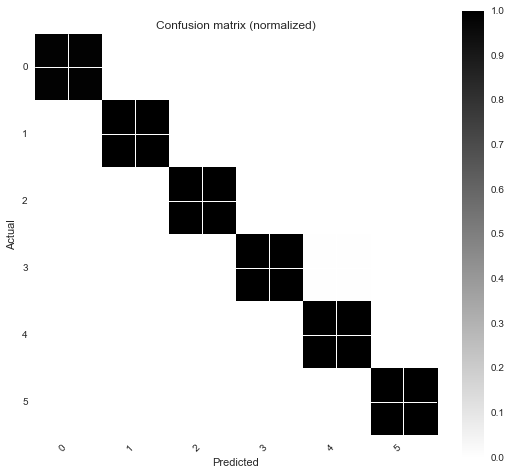

In [167]:
rf_tfidf_pred = rf_tfidf_model.predict(tfidf_platform.x_test)
ConfusionMatrix(tfidf_platform.y_test, rf_tfidf_pred).plot(normalized=True)

# Logistic Regression

In [ ]:
lr_tfidf_model = tfidf_platform.Logistic_Regression_OneVAll()

In [201]:
lr_tfidf_eval_dict = kfold_evaluation(tfidf_platform.x_test, tfidf_platform.y_test, model=lr_tfidf_model, kf=kf)
pd.DataFrame.from_dict(lr_tfidf_eval_dict)

,accuracy,f1,precision,recall
train,0.982667,0.982813,0.983037,0.982903
validate,0.982667,0.982617,0.983120,0.982640


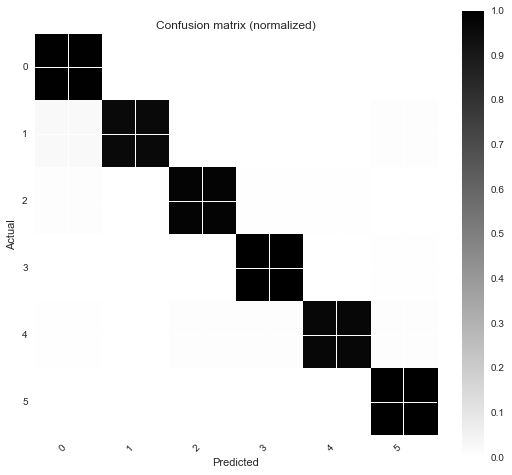

In [169]:
lr_tfidf_pred = lr_tfidf_model.predict(tfidf_platform.x_test)
ConfusionMatrix(tfidf_platform.y_test, lr_tfidf_pred).plot(normalized=True)

### SVC

In [ ]:
svc_tfidf_model = tfidf_platform.SVC_OneVAll()

In [202]:
svc_tfidf_eval_dict = kfold_evaluation(tfidf_platform.x_test, tfidf_platform.y_test, model=svc_tfidf_model, kf=kf)
pd.DataFrame.from_dict(svc_tfidf_eval_dict)

,accuracy,f1,precision,recall
train,0.984667,0.984690,0.984586,0.984926
validate,0.984667,0.984815,0.985270,0.984780


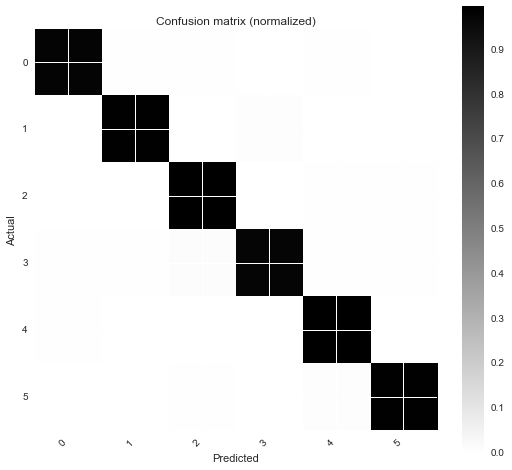

In [172]:
svc_tfidf_pred = svc_tfidf_model.predict(tfidf_platform.x_test)
ConfusionMatrix(tfidf_platform.y_test, svc_tfidf_pred).plot(normalized=True)

# Doc2Vec

In [174]:
d2v_platform = Classify_Thread(X=d2v_avg_embeddings,y=balanced_classes_data.thread_ids.values)

### Gridsearched MNB

In [179]:
# Gridsearched Multinomial Naive Bayes
mnb_d2v = d2v_platform.MNB_Gridsearch()
eval_d2v_dict = kfold_evaluation(d2v_platform.x_test, d2v_platform.y_test, model=mnb_d2v, kf=kf)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    165         sys.exit(msg)
    166     main_globals = sys.modules["__main__"].__dict__
    167     if alter_argv:
    168         sys.argv[0] = mod_spec.origin
    169     return _run_code(code, main_globals, None,
--> 170                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    171 
    172 def run_module(mod_name, init_globals=None,
    173                run_name=None, alter_sys=False):
    174     """Execute a module's code without importing it

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x1027c85d0, file "/Use...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/AnthonyAbercrombie/anaconda/lib/python3.5...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/Antho.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x1027c85d0, file "/Use...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/AnthonyAbercrombie/anaconda/lib/python3.5...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/Antho.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    584         
    585         If a global instance already exists, this reinitializes and starts it
    586         """
    587         app = cls.instance(**kwargs)
    588         app.initialize(argv)
--> 589         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    590 
    591 #-----------------------------------------------------------------------------
    592 # utility functions, for convenience
    593 #-----------------------------------------------------------------------------

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    400         
    401         if self.poller is not None:
    402             self.poller.start()
    403         self.kernel.start()
    404         try:
--> 405             ioloop.IOLoop.instance().start()
    406         except KeyboardInterrupt:
    407             pass
    408 
    409 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    255         if self.control_stream:
    256             self.control_stream.on_recv(self.dispatch_control, copy=False)
    257 
    258         def make_dispatcher(stream):
    259             def dispatcher(msg):
--> 260                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    261             return dispatcher
    262 
    263         for s in self.shell_streams:
    264             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Gridsearched Multinomial Naive Bayes\nmnb_d2v =..._test, d2v_platform.y_test, model=mnb_d2v, kf=kf)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-15T06:58:16.402202', 'msg_id': '2556C506EB31492CA3E8DDD5F35614E1', 'msg_type': 'execute_request', 'session': '17023023C91C46E1A8B31FC49A09B16E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '2556C506EB31492CA3E8DDD5F35614E1', 'msg_type': 'execute_request', 'parent_header': {}})
    207             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    208         else:
    209             self.log.debug("%s: %s", msg_type, msg)
    210             self.pre_handler_hook()
    211             try:
--> 212                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'17023023C91C46E1A8B31FC49A09B16E']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# Gridsearched Multinomial Naive Bayes\nmnb_d2v =..._test, d2v_platform.y_test, model=mnb_d2v, kf=kf)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-15T06:58:16.402202', 'msg_id': '2556C506EB31492CA3E8DDD5F35614E1', 'msg_type': 'execute_request', 'session': '17023023C91C46E1A8B31FC49A09B16E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '2556C506EB31492CA3E8DDD5F35614E1', 'msg_type': 'execute_request', 'parent_header': {}}
    213             except Exception:
    214                 self.log.error("Exception in message handler:", exc_info=True)
    215             finally:
    216                 self.post_handler_hook()

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'17023023C91C46E1A8B31FC49A09B16E'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Gridsearched Multinomial Naive Bayes\nmnb_d2v =..._test, d2v_platform.y_test, model=mnb_d2v, kf=kf)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-15T06:58:16.402202', 'msg_id': '2556C506EB31492CA3E8DDD5F35614E1', 'msg_type': 'execute_request', 'session': '17023023C91C46E1A8B31FC49A09B16E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '2556C506EB31492CA3E8DDD5F35614E1', 'msg_type': 'execute_request', 'parent_header': {}})
    365         if not silent:
    366             self.execution_count += 1
    367             self._publish_execute_input(code, parent, self.execution_count)
    368 
    369         reply_content = self.do_execute(code, silent, store_history,
--> 370                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    371 
    372         # Flush output before sending the reply.
    373         sys.stdout.flush()
    374         sys.stderr.flush()

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# Gridsearched Multinomial Naive Bayes\nmnb_d2v =..._test, d2v_platform.y_test, model=mnb_d2v, kf=kf)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    170 
    171         reply_content = {}
    172         # FIXME: the shell calls the exception handler itself.
    173         shell._reply_content = None
    174         try:
--> 175             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method InteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# Gridsearched Multinomial Naive Bayes\nmnb_d2v =..._test, d2v_platform.y_test, model=mnb_d2v, kf=kf)'
        store_history = True
        silent = False
    176         except:
    177             status = u'error'
    178             # FIXME: this code right now isn't being used yet by default,
    179             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Gridsearched Multinomial Naive Bayes\nmnb_d2v =..._test, d2v_platform.y_test, model=mnb_d2v, kf=kf)', store_history=True, silent=False, shell_futures=True)
   2897                 self.displayhook.exec_result = result
   2898 
   2899                 # Execute the user code
   2900                 interactivity = "none" if silent else self.ast_node_interactivity
   2901                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2902                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2903 
   2904                 # Reset this so later displayed values do not modify the
   2905                 # ExecutionResult
   2906                 self.displayhook.exec_result = None

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-179-5b023423b9a4>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3001 
   3002         try:
   3003             for i, node in enumerate(to_run_exec):
   3004                 mod = ast.Module([node])
   3005                 code = compiler(mod, cell_name, "exec")
-> 3006                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x184b80930, file "<ipython-input-179-5b023423b9a4>", line 2>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   3007                     return True
   3008 
   3009             for i, node in enumerate(to_run_interactive):
   3010                 mod = ast.Interactive([node])

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x184b80930, file "<ipython-input-179-5b023423b9a4>", line 2>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3061         outflag = 1  # happens in more places, so it's easier as default
   3062         try:
   3063             try:
   3064                 self.hooks.pre_run_code_hook()
   3065                 #rprint('Running code', repr(code_obj)) # dbg
-> 3066                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x184b80930, file "<ipython-input-179-5b023423b9a4>", line 2>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, ...}
   3067             finally:
   3068                 # Reset our crash handler in place
   3069                 sys.excepthook = old_excepthook
   3070         except SystemExit as e:

...........................................................................
/Users/AnthonyAbercrombie/gU/DSCI6004-student/final_project/<ipython-input-179-5b023423b9a4> in <module>()
      1 
----> 2 
      3 
      4 
      5 # Gridsearched Multinomial Naive Bayes
      6 mnb_d2v = d2v_platform.MNB_Gridsearch()
      7 eval_d2v_dict = kfold_evaluation(d2v_platform.x_test, d2v_platform.y_test, model=mnb_d2v, kf=kf)
      8 
      9 
     10 

...........................................................................
/Users/AnthonyAbercrombie/gU/DSCI6004-student/final_project/model.py in MNB_Gridsearch(self=<model.Classify_Thread object>)
    141                                      mnb_grid,
    142                                      n_jobs=-1,
    143                                      verbose=True,
    144                                      scoring='f1_macro')
    145         
--> 146         mnb_gridsearch.fit(self.x_train, self.y_train)
        mnb_gridsearch.fit = <bound method GridSearchCV.fit of GridSearchCV(c...t=True, scoring='f1_macro',
       verbose=True)>
        self.x_train = array([[-0.1486951 , -0.01766709, -0.06383126, ....       -0.0024603 ,  0.04538249]], dtype=float32)
        self.y_train = array([2, 4, 3, ..., 5, 5, 0])
    147         return mnb_gridsearch.best_estimator_
    148    
    149     def RandomForest(self):
    150         rf = RandomForestClassifier()

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ...it=True, scoring='f1_macro',
       verbose=True), X=array([[-0.1486951 , -0.01766709, -0.06383126, ....       -0.0024603 ,  0.04538249]], dtype=float32), y=array([2, 4, 3, ..., 5, 5, 0]))
    808         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    809             Target relative to X for classification or regression;
    810             None for unsupervised learning.
    811 
    812         """
--> 813         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...t=True, scoring='f1_macro',
       verbose=True)>
        X = array([[-0.1486951 , -0.01766709, -0.06383126, ....       -0.0024603 ,  0.04538249]], dtype=float32)
        y = array([2, 4, 3, ..., 5, 5, 0])
        self.param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0], 'fit_prior': [True, False]}
    814 
    815 
    816 class RandomizedSearchCV(BaseSearchCV):
    817     """Randomized search on hyper parameters.

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=None, error_score='raise',
     ...it=True, scoring='f1_macro',
       verbose=True), X=array([[-0.1486951 , -0.01766709, -0.06383126, ....       -0.0024603 ,  0.04538249]], dtype=float32), y=array([2, 4, 3, ..., 5, 5, 0]), parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    556         )(
    557             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    558                                     train, test, self.verbose, parameters,
    559                                     self.fit_params, return_parameters=True,
    560                                     error_score=self.error_score)
--> 561                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    562                 for train, test in cv)
    563 
    564         # Out is a list of triplet: score, estimator, n_test_samples
    565         n_fits = len(out)

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Dec 15 06:58:16 2016
PID: 23820      Python 3.5.1: /Users/AnthonyAbercrombie/anaconda/bin/python
...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True), memmap([[-0.1486951 , -0.01766709, -0.06383126, ...       -0.0024603 ,  0.04538249]], dtype=float32), array([2, 4, 3, ..., 5, 5, 0]), make_scorer(f1_score, average=macro, pos_label=None), array([1385, 1392, 1396, ..., 4497, 4498, 4499]), array([   0,    1,    2, ..., 1662, 1672, 1676]), True, {'alpha': 0.1, 'fit_prior': True}, {}), {'error_score': 'raise', 'return_parameters': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True), memmap([[-0.1486951 , -0.01766709, -0.06383126, ...       -0.0024603 ,  0.04538249]], dtype=float32), array([2, 4, 3, ..., 5, 5, 0]), make_scorer(f1_score, average=macro, pos_label=None), array([1385, 1392, 1396, ..., 4497, 4498, 4499]), array([   0,    1,    2, ..., 1662, 1672, 1676]), True, {'alpha': 0.1, 'fit_prior': True}, {})
        kwargs = {'error_score': 'raise', 'return_parameters': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True), X=memmap([[-0.1486951 , -0.01766709, -0.06383126, ...       -0.0024603 ,  0.04538249]], dtype=float32), y=array([2, 4, 3, ..., 5, 5, 0]), scorer=make_scorer(f1_score, average=macro, pos_label=None), train=array([1385, 1392, 1396, ..., 4497, 4498, 4499]), test=array([   0,    1,    2, ..., 1662, 1672, 1676]), verbose=True, parameters={'alpha': 0.1, 'fit_prior': True}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1608 
   1609     try:
   1610         if y_train is None:
   1611             estimator.fit(X_train, **fit_params)
   1612         else:
-> 1613             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseDiscreteNB.fit of MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)>
        X_train = memmap([[-0.08841698, -0.01179719, -0.03438913, ...       -0.0024603 ,  0.04538249]], dtype=float32)
        y_train = array([4, 4, 4, ..., 5, 5, 0])
        fit_params = {}
   1614 
   1615     except Exception as e:
   1616         if error_score == 'raise':
   1617             raise

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py in fit(self=MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True), X=array([[-0.08841698, -0.01179719, -0.03438913, ....       -0.0024603 ,  0.04538249]], dtype=float32), y=array([4, 4, 4, ..., 5, 5, 0]), sample_weight=None)
    582         # and feature log probas
    583         n_effective_classes = Y.shape[1]
    584         self.class_count_ = np.zeros(n_effective_classes, dtype=np.float64)
    585         self.feature_count_ = np.zeros((n_effective_classes, n_features),
    586                                        dtype=np.float64)
--> 587         self._count(X, Y)
        self._count = <bound method MultinomialNB._count of MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)>
        X = array([[-0.08841698, -0.01179719, -0.03438913, ....       -0.0024603 ,  0.04538249]], dtype=float32)
        Y = array([[ 0.,  0.,  0.,  0.,  1.,  0.],
       [ ...0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.]])
    588         self._update_feature_log_prob()
    589         self._update_class_log_prior(class_prior=class_prior)
    590         return self
    591 

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py in _count(self=MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True), X=array([[-0.08841698, -0.01179719, -0.03438913, ....       -0.0024603 ,  0.04538249]], dtype=float32), Y=array([[ 0.,  0.,  0.,  0.,  1.,  0.],
       [ ...0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.]]))
    685         self.class_prior = class_prior
    686 
    687     def _count(self, X, Y):
    688         """Count and smooth feature occurrences."""
    689         if np.any((X.data if issparse(X) else X) < 0):
--> 690             raise ValueError("Input X must be non-negative")
    691         self.feature_count_ += safe_sparse_dot(Y.T, X)
    692         self.class_count_ += Y.sum(axis=0)
    693 
    694     def _update_feature_log_prob(self):

ValueError: Input X must be non-negative
___________________________________________________________________________

In [ ]:
pd.DataFrame.from_dict(eval_d2v_dict)

In [ ]:
mnb_d2v_pred = mnb_d2v.predict(d2v_platform.x_test)
ConfusionMatrix(d2v_platform.y_test, mnb_d2v_pred).plot(normalized=True)

### Random Forest

In [176]:
# Random Forest
rf_d2v_model = d2v_platform.MNB_Gridsearch()
rf_d2v_eval_dict = kfold_evaluation(d2v_platform.x_test, d2v_platform.y_test, model=rf_d2v_model, kf=kf)
pd.DataFrame.from_dict(rf_d2v_eval_dict)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    165         sys.exit(msg)
    166     main_globals = sys.modules["__main__"].__dict__
    167     if alter_argv:
    168         sys.argv[0] = mod_spec.origin
    169     return _run_code(code, main_globals, None,
--> 170                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    171 
    172 def run_module(mod_name, init_globals=None,
    173                run_name=None, alter_sys=False):
    174     """Execute a module's code without importing it

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x1027c85d0, file "/Use...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/AnthonyAbercrombie/anaconda/lib/python3.5...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/Antho.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x1027c85d0, file "/Use...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/AnthonyAbercrombie/anaconda/lib/python3.5...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/Antho.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    584         
    585         If a global instance already exists, this reinitializes and starts it
    586         """
    587         app = cls.instance(**kwargs)
    588         app.initialize(argv)
--> 589         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    590 
    591 #-----------------------------------------------------------------------------
    592 # utility functions, for convenience
    593 #-----------------------------------------------------------------------------

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    400         
    401         if self.poller is not None:
    402             self.poller.start()
    403         self.kernel.start()
    404         try:
--> 405             ioloop.IOLoop.instance().start()
    406         except KeyboardInterrupt:
    407             pass
    408 
    409 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    878                 self._events.update(event_pairs)
    879                 while self._events:
    880                     fd, events = self._events.popitem()
    881                     try:
    882                         fd_obj, handler_func = self._handlers[fd]
--> 883                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    884                     except (OSError, IOError) as e:
    885                         if errno_from_exception(e) == errno.EPIPE:
    886                             # Happens when the client closes the connection
    887                             pass

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    255         if self.control_stream:
    256             self.control_stream.on_recv(self.dispatch_control, copy=False)
    257 
    258         def make_dispatcher(stream):
    259             def dispatcher(msg):
--> 260                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    261             return dispatcher
    262 
    263         for s in self.shell_streams:
    264             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Random Forest\nrf_d2v_model = d2v_platform.MNB_..., kf=kf)\npd.DataFrame.from_dict(rf_d2v_eval_dict)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-15T06:57:04.217633', 'msg_id': '438CBCB1D5B1481780DBF264409166B5', 'msg_type': 'execute_request', 'session': '17023023C91C46E1A8B31FC49A09B16E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '438CBCB1D5B1481780DBF264409166B5', 'msg_type': 'execute_request', 'parent_header': {}})
    207             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    208         else:
    209             self.log.debug("%s: %s", msg_type, msg)
    210             self.pre_handler_hook()
    211             try:
--> 212                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'17023023C91C46E1A8B31FC49A09B16E']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# Random Forest\nrf_d2v_model = d2v_platform.MNB_..., kf=kf)\npd.DataFrame.from_dict(rf_d2v_eval_dict)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-15T06:57:04.217633', 'msg_id': '438CBCB1D5B1481780DBF264409166B5', 'msg_type': 'execute_request', 'session': '17023023C91C46E1A8B31FC49A09B16E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '438CBCB1D5B1481780DBF264409166B5', 'msg_type': 'execute_request', 'parent_header': {}}
    213             except Exception:
    214                 self.log.error("Exception in message handler:", exc_info=True)
    215             finally:
    216                 self.post_handler_hook()

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'17023023C91C46E1A8B31FC49A09B16E'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Random Forest\nrf_d2v_model = d2v_platform.MNB_..., kf=kf)\npd.DataFrame.from_dict(rf_d2v_eval_dict)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-15T06:57:04.217633', 'msg_id': '438CBCB1D5B1481780DBF264409166B5', 'msg_type': 'execute_request', 'session': '17023023C91C46E1A8B31FC49A09B16E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '438CBCB1D5B1481780DBF264409166B5', 'msg_type': 'execute_request', 'parent_header': {}})
    365         if not silent:
    366             self.execution_count += 1
    367             self._publish_execute_input(code, parent, self.execution_count)
    368 
    369         reply_content = self.do_execute(code, silent, store_history,
--> 370                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    371 
    372         # Flush output before sending the reply.
    373         sys.stdout.flush()
    374         sys.stderr.flush()

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# Random Forest\nrf_d2v_model = d2v_platform.MNB_..., kf=kf)\npd.DataFrame.from_dict(rf_d2v_eval_dict)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    170 
    171         reply_content = {}
    172         # FIXME: the shell calls the exception handler itself.
    173         shell._reply_content = None
    174         try:
--> 175             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method InteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# Random Forest\nrf_d2v_model = d2v_platform.MNB_..., kf=kf)\npd.DataFrame.from_dict(rf_d2v_eval_dict)'
        store_history = True
        silent = False
    176         except:
    177             status = u'error'
    178             # FIXME: this code right now isn't being used yet by default,
    179             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Random Forest\nrf_d2v_model = d2v_platform.MNB_..., kf=kf)\npd.DataFrame.from_dict(rf_d2v_eval_dict)', store_history=True, silent=False, shell_futures=True)
   2897                 self.displayhook.exec_result = result
   2898 
   2899                 # Execute the user code
   2900                 interactivity = "none" if silent else self.ast_node_interactivity
   2901                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2902                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2903 
   2904                 # Reset this so later displayed values do not modify the
   2905                 # ExecutionResult
   2906                 self.displayhook.exec_result = None

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-176-5b06c1bf5c71>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3001 
   3002         try:
   3003             for i, node in enumerate(to_run_exec):
   3004                 mod = ast.Module([node])
   3005                 code = compiler(mod, cell_name, "exec")
-> 3006                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x11fd96390, file "<ipython-input-176-5b06c1bf5c71>", line 2>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   3007                     return True
   3008 
   3009             for i, node in enumerate(to_run_interactive):
   3010                 mod = ast.Interactive([node])

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x11fd96390, file "<ipython-input-176-5b06c1bf5c71>", line 2>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3061         outflag = 1  # happens in more places, so it's easier as default
   3062         try:
   3063             try:
   3064                 self.hooks.pre_run_code_hook()
   3065                 #rprint('Running code', repr(code_obj)) # dbg
-> 3066                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x11fd96390, file "<ipython-input-176-5b06c1bf5c71>", line 2>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, ...}
   3067             finally:
   3068                 # Reset our crash handler in place
   3069                 sys.excepthook = old_excepthook
   3070         except SystemExit as e:

...........................................................................
/Users/AnthonyAbercrombie/gU/DSCI6004-student/final_project/<ipython-input-176-5b06c1bf5c71> in <module>()
      1 
----> 2 
      3 
      4 
      5 # Random Forest
      6 rf_d2v_model = d2v_platform.MNB_Gridsearch()
      7 rf_d2v_eval_dict = kfold_evaluation(d2v_platform.x_test, d2v_platform.y_test, model=rf_d2v_model, kf=kf)
      8 pd.DataFrame.from_dict(rf_d2v_eval_dict)
      9 
     10 

...........................................................................
/Users/AnthonyAbercrombie/gU/DSCI6004-student/final_project/model.py in MNB_Gridsearch(self=<model.Classify_Thread object>)
    141                                      mnb_grid,
    142                                      n_jobs=-1,
    143                                      verbose=True,
    144                                      scoring='f1_macro')
    145         
--> 146         mnb_gridsearch.fit(self.x_train, self.y_train)
        mnb_gridsearch.fit = <bound method GridSearchCV.fit of GridSearchCV(c...t=True, scoring='f1_macro',
       verbose=True)>
        self.x_train = array([[-0.1486951 , -0.01766709, -0.06383126, ....       -0.0024603 ,  0.04538249]], dtype=float32)
        self.y_train = array([2, 4, 3, ..., 5, 5, 0])
    147         return mnb_gridsearch.best_estimator_
    148    
    149     def RandomForest(self):
    150         rf = RandomForestClassifier()

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ...it=True, scoring='f1_macro',
       verbose=True), X=array([[-0.1486951 , -0.01766709, -0.06383126, ....       -0.0024603 ,  0.04538249]], dtype=float32), y=array([2, 4, 3, ..., 5, 5, 0]))
    808         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    809             Target relative to X for classification or regression;
    810             None for unsupervised learning.
    811 
    812         """
--> 813         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method BaseSearchCV._fit of GridSearchCV(...t=True, scoring='f1_macro',
       verbose=True)>
        X = array([[-0.1486951 , -0.01766709, -0.06383126, ....       -0.0024603 ,  0.04538249]], dtype=float32)
        y = array([2, 4, 3, ..., 5, 5, 0])
        self.param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0], 'fit_prior': [True, False]}
    814 
    815 
    816 class RandomizedSearchCV(BaseSearchCV):
    817     """Randomized search on hyper parameters.

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=None, error_score='raise',
     ...it=True, scoring='f1_macro',
       verbose=True), X=array([[-0.1486951 , -0.01766709, -0.06383126, ....       -0.0024603 ,  0.04538249]], dtype=float32), y=array([2, 4, 3, ..., 5, 5, 0]), parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    556         )(
    557             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    558                                     train, test, self.verbose, parameters,
    559                                     self.fit_params, return_parameters=True,
    560                                     error_score=self.error_score)
--> 561                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    562                 for train, test in cv)
    563 
    564         # Out is a list of triplet: score, estimator, n_test_samples
    565         n_fits = len(out)

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV._fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Thu Dec 15 06:57:04 2016
PID: 23735      Python 3.5.1: /Users/AnthonyAbercrombie/anaconda/bin/python
...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True), memmap([[-0.1486951 , -0.01766709, -0.06383126, ...       -0.0024603 ,  0.04538249]], dtype=float32), array([2, 4, 3, ..., 5, 5, 0]), make_scorer(f1_score, average=macro, pos_label=None), array([1385, 1392, 1396, ..., 4497, 4498, 4499]), array([   0,    1,    2, ..., 1662, 1672, 1676]), True, {'alpha': 0.1, 'fit_prior': True}, {}), {'error_score': 'raise', 'return_parameters': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True), memmap([[-0.1486951 , -0.01766709, -0.06383126, ...       -0.0024603 ,  0.04538249]], dtype=float32), array([2, 4, 3, ..., 5, 5, 0]), make_scorer(f1_score, average=macro, pos_label=None), array([1385, 1392, 1396, ..., 4497, 4498, 4499]), array([   0,    1,    2, ..., 1662, 1672, 1676]), True, {'alpha': 0.1, 'fit_prior': True}, {})
        kwargs = {'error_score': 'raise', 'return_parameters': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py in _fit_and_score(estimator=MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True), X=memmap([[-0.1486951 , -0.01766709, -0.06383126, ...       -0.0024603 ,  0.04538249]], dtype=float32), y=array([2, 4, 3, ..., 5, 5, 0]), scorer=make_scorer(f1_score, average=macro, pos_label=None), train=array([1385, 1392, 1396, ..., 4497, 4498, 4499]), test=array([   0,    1,    2, ..., 1662, 1672, 1676]), verbose=True, parameters={'alpha': 0.1, 'fit_prior': True}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1608 
   1609     try:
   1610         if y_train is None:
   1611             estimator.fit(X_train, **fit_params)
   1612         else:
-> 1613             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseDiscreteNB.fit of MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)>
        X_train = memmap([[-0.08841698, -0.01179719, -0.03438913, ...       -0.0024603 ,  0.04538249]], dtype=float32)
        y_train = array([4, 4, 4, ..., 5, 5, 0])
        fit_params = {}
   1614 
   1615     except Exception as e:
   1616         if error_score == 'raise':
   1617             raise

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py in fit(self=MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True), X=array([[-0.08841698, -0.01179719, -0.03438913, ....       -0.0024603 ,  0.04538249]], dtype=float32), y=array([4, 4, 4, ..., 5, 5, 0]), sample_weight=None)
    582         # and feature log probas
    583         n_effective_classes = Y.shape[1]
    584         self.class_count_ = np.zeros(n_effective_classes, dtype=np.float64)
    585         self.feature_count_ = np.zeros((n_effective_classes, n_features),
    586                                        dtype=np.float64)
--> 587         self._count(X, Y)
        self._count = <bound method MultinomialNB._count of MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)>
        X = array([[-0.08841698, -0.01179719, -0.03438913, ....       -0.0024603 ,  0.04538249]], dtype=float32)
        Y = array([[ 0.,  0.,  0.,  0.,  1.,  0.],
       [ ...0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.]])
    588         self._update_feature_log_prob()
    589         self._update_class_log_prior(class_prior=class_prior)
    590         return self
    591 

...........................................................................
/Users/AnthonyAbercrombie/anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py in _count(self=MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True), X=array([[-0.08841698, -0.01179719, -0.03438913, ....       -0.0024603 ,  0.04538249]], dtype=float32), Y=array([[ 0.,  0.,  0.,  0.,  1.,  0.],
       [ ...0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.]]))
    685         self.class_prior = class_prior
    686 
    687     def _count(self, X, Y):
    688         """Count and smooth feature occurrences."""
    689         if np.any((X.data if issparse(X) else X) < 0):
--> 690             raise ValueError("Input X must be non-negative")
    691         self.feature_count_ += safe_sparse_dot(Y.T, X)
    692         self.class_count_ += Y.sum(axis=0)
    693 
    694     def _update_feature_log_prob(self):

ValueError: Input X must be non-negative
___________________________________________________________________________

In [ ]:
rf_d2v_pred = rf_d2v_model.predict(d2v_platform.x_test)
ConfusionMatrix(d2v_platform.y_test, rf_d2v_pred).plot(normalized=True)

### One vs Rest Logistic Regression

In [ ]:
lr_d2v_model = d2v_platform.Logistic_Regression_OneVAll()

In [203]:
lr_d2v_eval_dict = kfold_evaluation(d2v_platform.x_test, d2v_platform.y_test, model=lr_d2v_model, kf=kf)
pd.DataFrame.from_dict(lr_d2v_eval_dict)

,accuracy,f1,precision,recall
train,0.594,0.581789,0.753047,0.593992
validate,0.594,0.580814,0.752642,0.594156


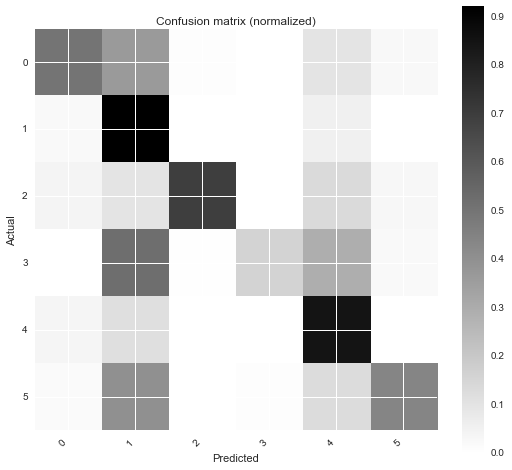

In [182]:
lr_d2v_pred = lr_d2v_model.predict(d2v_platform.x_test)
ConfusionMatrix(d2v_platform.y_test, lr_d2v_pred).plot(normalized=True)

### One vs Rest SVC

In [ ]:
svc_d2v_model = d2v_platform.SVC_OneVAll()

In [204]:
svc_d2v_eval_dict = kfold_evaluation(d2v_platform.x_test, d2v_platform.y_test, model=svc_d2v_model, kf=kf)
pd.DataFrame.from_dict(svc_d2v_eval_dict)

,accuracy,f1,precision,recall
train,0.527333,0.508789,0.736024,0.536623
validate,0.527333,0.506760,0.735336,0.537157


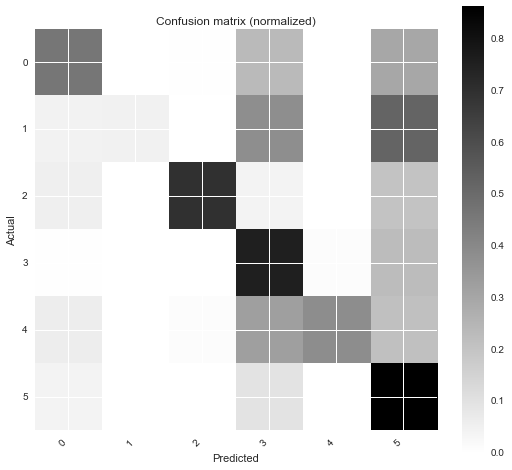

In [205]:
svc_d2v_pred = svc_d2v_model.predict(d2v_platform.x_test)
ConfusionMatrix(d2v_platform.y_test, svc_d2v_pred).plot(normalized=True)

## Conclusion:

### Best model for BOW was Multinomial Naive Bayes.

In [206]:
pd.DataFrame.from_dict(eval_dict)

,accuracy,f1,precision,recall
train,0.988,0.988202,0.988276,0.988236
validate,0.988,0.987941,0.988007,0.988217


### Best model for TFIDF was Random Forest

In [207]:
pd.DataFrame.from_dict(rf_tfidf_eval_dict)

,accuracy,f1,precision,recall
train,0.996667,0.996744,0.996664,0.996854
validate,0.996667,0.996749,0.996869,0.996718


### Classification was problematic with Doc2Vec, clustering may be a better approach.

In [189]:
from sklearn.neighbors import KNeighborsClassifier
knn_d2v = KNeighborsClassifier(50)
knn_d2v.fit(d2v_platform.x_train, d2v_platform.y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')

In [190]:
knn_d2v_eval_dict = kfold_evaluation(d2v_platform.x_test, d2v_platform.y_test, model=knn_d2v, kf=kf)
pd.DataFrame.from_dict(svc_d2v_eval_dict)

,accuracy,f1,precision,recall
train,0.574,0.571955,0.791168,0.573187
validate,0.560,0.556000,0.714893,0.561955


## Next: Autotagging